### Final Project motor task classification using EEG Data

#### Importing necessary libraries

In [3]:
import numpy as np
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [40]:
cd /content/gdrive/Shareddrives/C247

/content/gdrive/Shareddrives/C247


In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import activations

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from load_data import *
from sklearn.model_selection import KFold

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# Loading full data
data_path = './project'

X_train_valid, y_train_valid, X_test, y_test, person_train_valid, person_test = load_full_data(data_path)

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115,)
Person test shape: (443,)


In [6]:
## Adjusting the labels to {0,1,2,3}

# left hand - 0
# right hand - 1
# feet motion - 2
# tongue motion - 3

# labels are given as {769, 770, 771, 772}
base = y_train_valid.min()
y_train_valid-= base
y_test-= base

In [7]:
# Getting data for individual subjects

subject_data_train = split_data_by_subject(X_train_valid, y_train_valid, person_train_valid)
subject_data_test = split_data_by_subject(X_test, y_test, person_test)

In [8]:
# Changing of data dimensions

print ('Shape of training set: {}'.format(X_train_valid.shape))
print ('Shape of test set: {}'.format(X_test.shape))
print ('Shape of train labels: {}'.format(y_train_valid.shape))
print ('Shape of test labels: {}'.format(y_test.shape))

y_train_cv = to_categorical(y_train_valid, 4)
y_test_cv = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:', y_train_cv.shape)
print('Shape of test labels after categorical conversion:', y_test_cv.shape)

# Adding width of the segment to be 1
x_train_cv = X_train_valid.reshape(X_train_valid.shape[0], X_train_valid.shape[1], X_train_valid.shape[2], 1)
x_test_cv = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train_cv.shape)
print('Shape of test set after adding width info:',x_test_cv.shape)


# Reshaping the training and validation dataset
x_train_cv = np.swapaxes(x_train_cv, 1,3)
x_train_cv = np.swapaxes(x_train_cv, 1,2)

x_test_cv = np.swapaxes(x_test_cv, 1,3)
x_test_cv = np.swapaxes(x_test_cv, 1,2)
print('Shape of training set after dimension reshaping:',x_train_cv.shape)

print('Shape of test set after dimension reshaping:',x_test_cv.shape)

Shape of training set: (2115, 22, 1000)
Shape of test set: (443, 22, 1000)
Shape of train labels: (2115,)
Shape of test labels: (443,)
Shape of training labels after categorical conversion: (2115, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (2115, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: (2115, 1000, 1, 22)
Shape of test set after dimension reshaping: (443, 1000, 1, 22)


In [9]:
def data_prep(X,y,window_size,sub_sample,average,noise):
    # N,H,W,C ----- N,1000,1,22
    total_X = None
    total_y = None
    X = X[:,0:window_size,:,:]
    Xi = X
    X = np.transpose(X, (0,2, 3, 1))
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], X.shape[2],-1, sub_sample), axis=4)   # N,W,C,H/sub_sample
    
    X_max = np.transpose(X_max, (0,3,1, 2))
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape,y.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], X.shape[2],-1, sub_sample), axis=4)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    X_average = np.transpose(X_average, (0,3,1, 2))

    total_X = np.vstack((total_X, X_average))
    total_y = np.vstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape,y.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = Xi[:,i::sub_sample, :, :] + \
                            (np.random.normal(0.0, 0.5, Xi[:,i::sub_sample, :, :].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.vstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape,y.shape)
    return total_X,total_y



#Building 2D CNN 

In [41]:
from project.helpers import *

In [78]:
X_train, X_val, y_train, y_val = train_test_split(x_train_cv, y_train_cv, test_size=0.2, random_state=42)

In [12]:
tf.keras.backend.clear_session()

In [79]:
window_size = 500
print(X_train.shape,y_train.shape)
# X_train_dp,y_train_dp = data_prep(X_train,y_train,window_size,2,2,True)
X_train_grv = conv2DPrepreprocessing(X_train,5)
y_train_grv = y_train
print(X_train_grv.shape,y_train_grv.shape)

(1692, 1000, 1, 22) (1692, 4)
(1692, 5, 200, 22) (1692, 4)


In [80]:
print(X_val.shape,y_val.shape)
# X_val_dp,y_val_dp = data_prep(X_val,y_val,window_size,2,2,True)
X_val_grv = conv2DPrepreprocessing(X_val,5)
y_val_grv = y_val
print(X_val_grv.shape,y_val_grv.shape)

(423, 1000, 1, 22) (423, 4)
(423, 5, 200, 22) (423, 4)


In [81]:
print(x_test_cv.shape,y_test_cv.shape)
# x_test_dp,y_test_dp = data_prep(x_test_cv,y_test_cv,window_size,2,2,True)
x_test_grv = conv2DPrepreprocessing(x_test_cv,5)
y_test_grv = y_test_cv
print(x_test_grv.shape,y_test_grv.shape)

(443, 1000, 1, 22) (443, 4)
(443, 5, 200, 22) (443, 4)


In [16]:
# import tensorflow as tf
from tensorflow.keras.layers import PReLU
import tensorflow

In [18]:
# Building the CNN model using sequential class
tf.keras.backend.clear_session()
def get_mode()
basic_cnn_model2d = Sequential()

# Conv. block 1
basic_cnn_model2d.add(Conv2D(filters=16, kernel_size=(3,7), padding='same', activation='elu', input_shape=(5, 200, 22)))
basic_cnn_model2d.add(MaxPooling2D(pool_size=(2,2), padding='same')) # Read the keras documentation
basic_cnn_model2d.add(BatchNormalization())
basic_cnn_model2d.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model2d.add(Conv2D(filters=32, kernel_size=(3,7), padding='same', activation='elu'))
basic_cnn_model2d.add(MaxPooling2D(pool_size=(2,2), padding='same'))
basic_cnn_model2d.add(BatchNormalization())
basic_cnn_model2d.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model2d.add(Conv2D(filters=64, kernel_size=(3,7), padding='same', activation='elu'))
basic_cnn_model2d.add(MaxPooling2D(pool_size=(2,2), padding='same'))
basic_cnn_model2d.add(BatchNormalization())
basic_cnn_model2d.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model2d.add(Conv2D(filters=128, kernel_size=(3,7), padding='same', activation='elu'))
basic_cnn_model2d.add(MaxPooling2D(pool_size=(2,2), padding='same'))
basic_cnn_model2d.add(BatchNormalization())
basic_cnn_model2d.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model2d.add(Flatten()) # Flattens the input
basic_cnn_model2d.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model2d.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 200, 16)        7408      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 100, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 100, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3, 100, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 100, 32)        10784     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 50, 32)        0

In [34]:
# Model parameters
learning_rate = 1e-5
epochs = 50
cnn_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [35]:
basic_cnn_model2d.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results_2d = basic_cnn_model2d.fit(X_train_grv,
             y_train_grv,
             batch_size=64,
             epochs=epochs,
             validation_data=(X_val_grv, y_val_grv), verbose=True)



Epoch 1/50
27/27 [==============================] - 2s 24ms/step - loss: 0.2511 - accuracy: 0.9125 - val_loss: 0.8758 - val_accuracy: 0.7210
Epoch 2/50
27/27 [==============================] - 0s 13ms/step - loss: 0.2392 - accuracy: 0.9084 - val_loss: 0.8838 - val_accuracy: 0.7116
Epoch 3/50
27/27 [==============================] - 0s 13ms/step - loss: 0.2304 - accuracy: 0.9190 - val_loss: 0.8901 - val_accuracy: 0.7139
Epoch 4/50
27/27 [==============================] - 0s 12ms/step - loss: 0.2397 - accuracy: 0.9125 - val_loss: 0.8860 - val_accuracy: 0.7116
Epoch 5/50
27/27 [==============================] - 0s 13ms/step - loss: 0.2450 - accuracy: 0.9013 - val_loss: 0.8834 - val_accuracy: 0.7116
Epoch 6/50
27/27 [==============================] - 0s 12ms/step - loss: 0.2284 - accuracy: 0.9149 - val_loss: 0.8837 - val_accuracy: 0.7069
Epoch 7/50
27/27 [==============================] - 0s 12ms/step - loss: 0.2318 - accuracy: 0.9084 - val_loss: 0.8918 - val_accuracy: 0.7092
Epoch 8/50
27

In [36]:
## Testing the basic CNN model

cnn_score = basic_cnn_model2d.evaluate(x_test_grv, y_test_grv, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.7065462470054626


In [37]:
prediction = np.argmax(basic_cnn_model2d.predict(x_test_grv),axis=1)

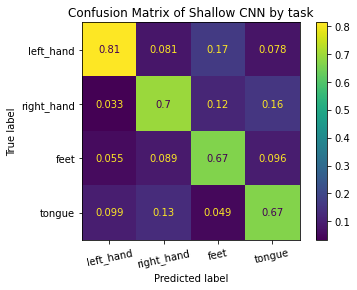

In [44]:
labels = ['left_hand','right_hand','feet','tongue']
plot_confusion_matrix(y_test,prediction,labels)

In [45]:
scorec = []
for i in range(9):
    _, _, x_test_sub, y_test_sub = getSubjectData(X_train_valid, y_train_valid, X_test, y_test,
                                                                    person_train_valid, person_test, i)
    x_test_sub = conv2DPrepreprocessing(x_test_sub,5)
    cnn_score = basic_cnn_model2d.evaluate(x_test_sub, y_test_sub, verbose=0)
    scorec.append(cnn_score[1])
    

Shape of training labels after categorical conversion: (237, 4)
Shape of test labels after categorical conversion: (50, 4)
Shape of training set after adding width info: (237, 22, 1000, 1)
Shape of test set after adding width info: (50, 22, 1000, 1)
Shape of final training set:  (237, 1000, 1, 22)
Shape of final test set : (50, 1000, 1, 22)
Shape of training labels after categorical conversion: (236, 4)
Shape of test labels after categorical conversion: (50, 4)
Shape of training set after adding width info: (236, 22, 1000, 1)
Shape of test set after adding width info: (50, 22, 1000, 1)
Shape of final training set:  (236, 1000, 1, 22)
Shape of final test set : (50, 1000, 1, 22)
Shape of training labels after categorical conversion: (236, 4)
Shape of test labels after categorical conversion: (50, 4)
Shape of training set after adding width info: (236, 22, 1000, 1)
Shape of test set after adding width info: (50, 22, 1000, 1)
Shape of final training set:  (236, 1000, 1, 22)
Shape of final 

In [46]:
print(scorec)

[0.5799999833106995, 0.6000000238418579, 0.8399999737739563, 0.7799999713897705, 0.7234042286872864, 0.6530612111091614, 0.7200000286102295, 0.699999988079071, 0.7659574747085571]


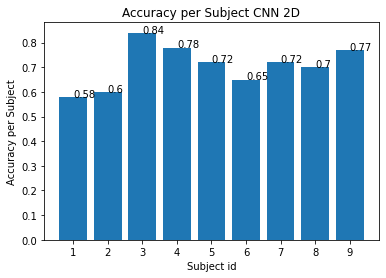

In [64]:
import matplotlib.pyplot as plt
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])
x = [u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8',u'9']
# y = [160, 167, 137, 18, 120, 36, 155, 130]
ind = np.arange(len(scorec))

t = np.round(t,2)
plt.bar(x, t)
addlabels(x, t)
      
# giving title to the plot
plt.title("Accuracy per Subject CNN 2D")
    
# giving X and Y labels
plt.xlabel("Subject id")
plt.ylabel("Accuracy per Subject")
    
# visualizing the plot
plt.show()

In [62]:
print()

[0.58 0.6  0.84 0.78 0.72 0.65 0.72 0.7  0.77]


In [73]:
def get_model(input_size):
    basic_cnn_model2d = Sequential()

    # Conv. block 1
    basic_cnn_model2d.add(Conv2D(filters=16, kernel_size=(3,7), padding='same', activation='elu', input_shape=(5, input_size, 22)))
    basic_cnn_model2d.add(MaxPooling2D(pool_size=(2,2), padding='same')) # Read the keras documentation
    basic_cnn_model2d.add(BatchNormalization())
    basic_cnn_model2d.add(Dropout(0.5))

    # Conv. block 2
    basic_cnn_model2d.add(Conv2D(filters=32, kernel_size=(3,7), padding='same', activation='elu'))
    basic_cnn_model2d.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    basic_cnn_model2d.add(BatchNormalization())
    basic_cnn_model2d.add(Dropout(0.5))

    # Conv. block 3
    basic_cnn_model2d.add(Conv2D(filters=64, kernel_size=(3,7), padding='same', activation='elu'))
    basic_cnn_model2d.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    basic_cnn_model2d.add(BatchNormalization())
    basic_cnn_model2d.add(Dropout(0.5))

    # Conv. block 4
    basic_cnn_model2d.add(Conv2D(filters=128, kernel_size=(3,7), padding='same', activation='elu'))
    basic_cnn_model2d.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    basic_cnn_model2d.add(BatchNormalization())
    basic_cnn_model2d.add(Dropout(0.5))

    # Output layer with Softmax activation
    basic_cnn_model2d.add(Flatten()) # Flattens the input
    basic_cnn_model2d.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


    # Printing the model summary
    # basic_cnn_model2d.summary()
    return basic_cnn_model2d

In [ ]:
# def get_accuracy(model,x,y):


In [93]:
cnn_score_val = []
cnn_score_train = []
for i in range(100,1001,100):

    X_train_chk = conv2DPrepreprocessing(x_train_cv[:, 0: i,:,:],5)
    y_train_chk = y_train_cv
    print(i)
    print(10*"-")
    tf.keras.backend.clear_session()
    model = get_model(i//5)
    learning_rate = 1e-4
    epochs = 500
    cnn_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

    # Training and validating the model
    print(X_train_chk.shape)
    basic_cnn_model_results_2d = model.fit(X_train_chk,
                y_train_chk,
                batch_size=64,
                epochs=epochs, verbose=0)
    X_test_grv1 = conv2DPrepreprocessing(x_test_cv[:, 0: i,:,:],5)
    print(10*"-")
    print(X_test_grv1.shape)
    cnn_score_val.append(model.evaluate(X_test_grv1, y_test_grv, verbose=0)[1])
    cnn_score_train.append(model.evaluate(X_train_chk, y_train_cv, verbose=0)[1])
    

100
----------
(2115, 5, 20, 22)
----------
(443, 5, 20, 22)
200
----------
(2115, 5, 40, 22)
----------
(443, 5, 40, 22)
300
----------
(2115, 5, 60, 22)
----------
(443, 5, 60, 22)
400
----------
(2115, 5, 80, 22)
----------
(443, 5, 80, 22)
500
----------
(2115, 5, 100, 22)
----------
(443, 5, 100, 22)
600
----------
(2115, 5, 120, 22)
----------
(443, 5, 120, 22)
700
----------
(2115, 5, 140, 22)
----------
(443, 5, 140, 22)
800
----------
(2115, 5, 160, 22)
----------
(443, 5, 160, 22)
900
----------
(2115, 5, 180, 22)
----------
(443, 5, 180, 22)
1000
----------
(2115, 5, 200, 22)
----------
(443, 5, 200, 22)


In [94]:
cnn_score_val

[0.544018030166626,
 0.6252821683883667,
 0.6930022835731506,
 0.6681715846061707,
 0.7065462470054626,
 0.7042889595031738,
 0.6930022835731506,
 0.7178329825401306,
 0.7246049642562866,
 0.6817155480384827]

In [95]:
cnn_score_train

[0.7451536655426025,
 0.8222222328186035,
 0.8751773238182068,
 0.8931441903114319,
 0.9290780425071716,
 0.9267139434814453,
 0.9172576665878296,
 0.9432623982429504,
 0.9484633803367615,
 0.9286051988601685]

In [2]:
a = [0.544018030166626,
 0.6252821683883667,
 0.6930022835731506,
 0.6681715846061707,
 0.7065462470054626,
 0.7042889595031738,
 0.6930022835731506,
 0.7178329825401306,
 0.7246049642562866,
 0.6817155480384827]

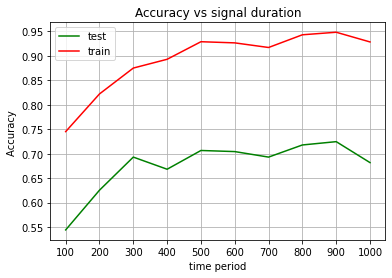

In [14]:
import matplotlib.pyplot as plt
x = [u'100', u'200', u'300', u'400', u'500', u'600', u'700', u'800',u'900',u'1000']
# y = [160, 167, 137, 18, 120, 36, 155, 130]
t = [0.7451536655426025,
 0.8222222328186035,
 0.8751773238182068,
 0.8931441903114319,
 0.9290780425071716,
 0.9267139434814453,
 0.9172576665878296,
 0.9432623982429504,
 0.9484633803367615,
 0.9286051988601685]
# t = np.round(t,2)
# plt.bar(x, t)
plt.plot(x,a,'g')
plt.plot(x,t,'r')
plt.legend(['test','train'])
plt.title("Accuracy vs signal duration")
    
# giving X and Y labels
plt.xlabel("time period")
plt.ylabel("Accuracy ")
plt.grid()
plt.show()


In [4]:
import numpy as np
a = np.array([0.58,0.6,0.84,0.78,0.72,0.65,0.72,0.7,0.77])

In [5]:
np.std(a)

0.0804155872120988

In [6]:
np.mean(a)

0.7066666666666666